<a href="https://colab.research.google.com/github/EllieZhangy/Artwork-Classification-and-Style-Transfer/blob/main/Code_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artwork Classification and Style Transfer
## Task2: Style Transfer (Transfer Learning)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.preprocessing.image import load_img

import os
from PIL import Image
import os

## 1.Data Load

In [ ]:
content_image_path='/content/drive/MyDrive/Deep Learning/tops_images/Vincent_van_Gogh/Vincent_van_Gogh_84.jpg'
style_image_path='/content/drive/MyDrive/Deep Learning/tops_images/Francisco_Goya/Francisco_Goya_100.jpg'

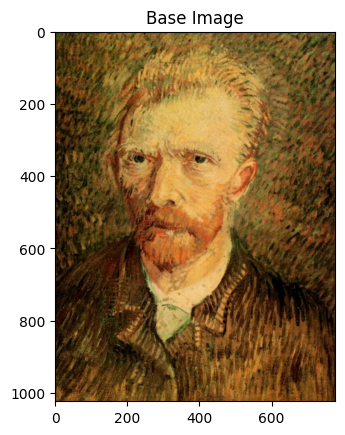

In [ ]:
plt.figure()
plt.title("Base Image")
img1 = load_img(content_image_path)
plt.imshow(img1)

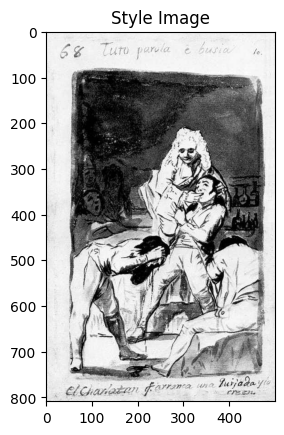

In [ ]:
plt.figure()
plt.title("Style Image")
img1 = load_img(style_image_path)
plt.imshow(img1)

## 2.Define Function

In [ ]:
size=360

In [ ]:
def read_img(path):
    img=tf.keras.preprocessing.image.load_img(path,target_size=(size,size))
    img=tf.keras.preprocessing.image.img_to_array(img,dtype='uint8')
    img=np.expand_dims(img,axis=0)
    return img

In [ ]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return np.expand_dims(img, axis = 0)

In [ ]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

## 3.Model1: Transfer Learning based on VGG19

### 3.1 Model Architecture

In [ ]:
model=VGG19(include_top=False,input_shape=(size,size,3))
model.trainable=False
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 360, 360, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 360, 360, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 360, 360, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 180, 180, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 180, 180, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 180, 180, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 90, 90, 128)       0     

In [ ]:
content_layer='block3_conv4'
content_model=Model(inputs=model.input,outputs=model.get_layer(content_layer).output)

In [ ]:
style_layers=[ 'block1_conv1', 'block2_conv2','block3_conv3', 'block4_conv4','block5_conv2']
style_models=[Model(inputs=model.input,outputs=model.get_layer(style_layer).output) for style_layer in style_layers]

In [ ]:
# define gram_matrix, content_cost and style_cost
def gram_matrix(M):
    num_channels = tf.shape(M)[-1]
    M = tf.reshape(M, shape=(-1, num_channels))
    n = tf.shape(M)[0]
    G = tf.matmul(tf.transpose(M), M)
    return G
def content_cost(content_img, generated_img):
    C = content_model(content_img)
    G = content_model(generated_img)
    cost =  tf.reduce_mean(tf.square(generated_img-content_img))
    return cost
def style_cost(style_img, generated_img, style_layer_wts):  # <- Add the argument here
    total_cost = 0

    for i, style_model in enumerate(style_models):
        S = style_model(style_img)
        G = style_model(generated_img)
        GS = gram_matrix(S)
        GG = gram_matrix(G)
        current_cost = style_layer_wts[i] * tf.reduce_mean(tf.square(GS-GG))
        total_cost += current_cost
    return total_cost

### 3.2 Generate the Styled Image

In [ ]:
def generate(content_image_path, style_image_path, lr, iterations, style_wt, content_wt, style_layer_wts):
    content_image_preprocessed = preprocess_image(content_image_path)
    style_image_preprocessed = preprocess_image(style_image_path)
    generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)

    generated_images = []
    costs = []

    min_cost = 1 * 10 ** 12
    optimizer = tf.optimizers.Adam(learning_rate=lr)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content_img=content_image_preprocessed, generated_img=generated_image)
            J_style = style_cost(style_img=style_image_preprocessed, generated_img=generated_image, style_layer_wts=style_layer_wts)
            J_total = content_wt * J_content + style_wt * J_style

        gradients = tape.gradient(J_total, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])

        costs.append(J_total.numpy())
        generated_images.append(generated_image.numpy())

        if i % 50 == 0:
            print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i + 1, iterations, J_total, J_style, J_content))

    return generated_images, costs

### 3.3 Hyper-Parameter Selectioin

In [ ]:
# Original Hyperparameters
lr_original = 23
iterations_original = 250
style_wt_original = 0.008
content_wt_original = 0.8
style_layer_wts_original = [4,2,1,0.1,0.1]

In [ ]:
# Tuning Hyperparameters
lr_tuned = 10
iterations_tuned = 300
style_wt_tuned = 0.01
content_wt_tuned = 0.7
style_layer_wts_tuned = [4,2,1,0.2,0.2]

In [ ]:
generated_images_original, costs_original = generate(content_image_path, style_image_path, lr_original, iterations_original, style_wt_original, content_wt_original, style_layer_wts_original)
original_generated_image = Image.fromarray(deprocess(generated_images_original[-1][0]))

Iteration:1/250, Total Cost:2.8796546686386176e+16, Style Cost: 3.5995682477514424e+18, Content Cost: 0.0
Iteration:51/250, Total Cost:956776576974848.0, Style Cost: 1.1959706661892915e+17, Content Cost: 5182.419921875
Iteration:101/250, Total Cost:167644502163456.0, Style Cost: 2.095556204901171e+16, Content Cost: 7261.5205078125
Iteration:151/250, Total Cost:38586208485376.0, Style Cost: 4823275653824512.0, Content Cost: 8153.93359375
Iteration:201/250, Total Cost:21197714620416.0, Style Cost: 2649714306580480.0, Content Cost: 8295.6103515625


In [ ]:
generated_images_tuned, costs_tuned = generate(content_image_path, style_image_path, lr_tuned, iterations_tuned, style_wt_tuned, content_wt_tuned, style_layer_wts_tuned)
tuned_generated_image = Image.fromarray(deprocess(generated_images_tuned[-1][0]))

Iteration:1/300, Total Cost:3.599572362330112e+16, Style Cost: 3.5995723709200466e+18, Content Cost: 0.0
Iteration:51/300, Total Cost:1143820389449728.0, Style Cost: 1.1438204001871462e+17, Content Cost: 4380.298828125
Iteration:101/300, Total Cost:160430718713856.0, Style Cost: 1.6043072945127424e+16, Content Cost: 6672.3388671875
Iteration:151/300, Total Cost:40059310964736.0, Style Cost: 4005931297800192.0, Content Cost: 7499.05126953125
Iteration:201/300, Total Cost:24860529000448.0, Style Cost: 2486052967153664.0, Content Cost: 7625.7158203125
Iteration:251/300, Total Cost:18329020399616.0, Style Cost: 1832902123847680.0, Content Cost: 7665.99951171875


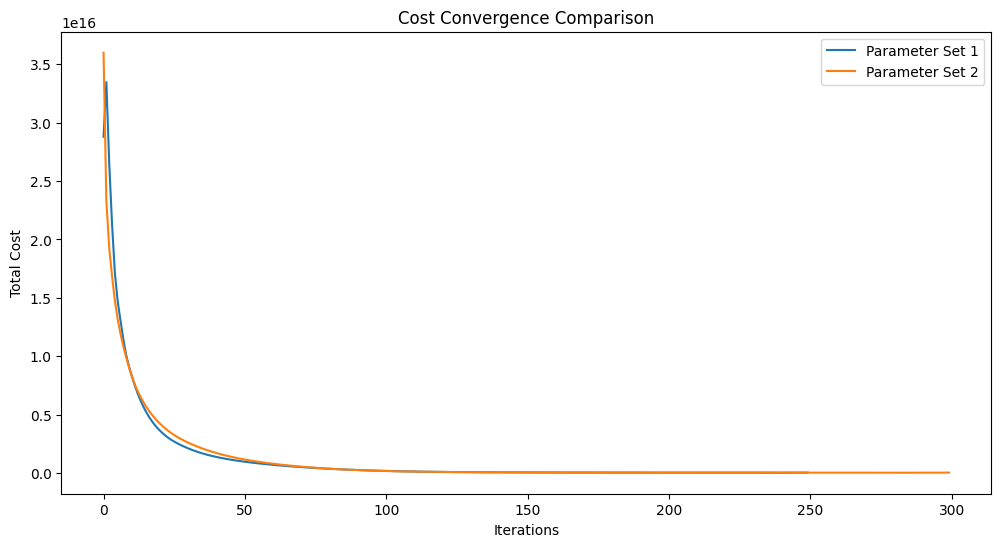

In [ ]:
# Plot the Costs Over Iterations
plt.figure(figsize=(12,6))
plt.plot(costs_original, label="Parameter Set 1")
plt.plot(costs_tuned, label="Parameter Set 2")
plt.xlabel('Iterations')
plt.ylabel('Total Cost')
plt.title('Cost Convergence Comparison')
plt.legend()
plt.savefig('cost_comparison.png')
plt.show()

In [ ]:
print(costs_original[-1])

26038235000000.0


In [ ]:
model_dir = '/content/drive/MyDrive/DL_Final/Models/'
model.save(model_dir +'style_transfer_vgg19.h5')

### 3.4 Result Analysis

<function matplotlib.pyplot.show(close=None, block=None)>

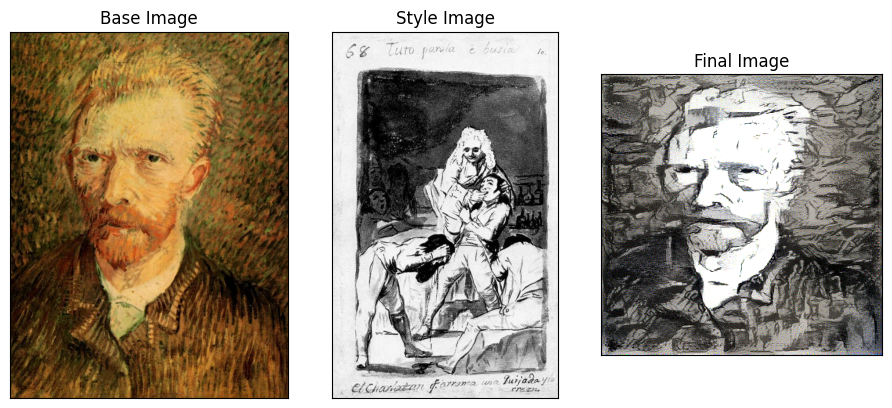

In [ ]:
plt.figure(figsize=(12,8))
dict_title={1:"Base Image",2:"Style Image",3:"Final Image"}
images={1:tf.keras.preprocessing.image.load_img(content_image_path),2:tf.keras.preprocessing.image.load_img(style_image_path), 3:original_generated_image}
for i in range(1,4):
    plt.subplot(2,4,i)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(dict_title[i])
plt.savefig('out2.png')
plt.show

## 4.Model2: Transfer Learning based on ResNet

### 4.1 Model Architecture

In [ ]:
from tensorflow.keras.applications import ResNet50

model = ResNet50(include_top=False, weights='imagenet', input_shape=(size, size, 3))
model.trainable = False
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 360, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 366, 366, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 180, 180, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
content_layer = 'conv3_block4_out'
content_model = Model(inputs=model.input, outputs=model.get_layer(content_layer).output)

style_layers = [
    'conv1_relu',
    'conv2_block3_out',
    'conv3_block4_out',
    'conv4_block6_out',
    'conv5_block3_out'
]
style_models = [Model(inputs=model.input, outputs=model.get_layer(style_layer).output) for style_layer in style_layers]


### 4.2 Model Traning

In [ ]:
# Original Hyperparameters
lr_original = 23
iterations_original = 250
style_wt_original = 0.008
content_wt_original = 0.8
style_layer_wts_original = [4,2,1,0.1,0.1]

In [ ]:
# Tuning Hyperparameters
lr_tuned = 10
iterations_tuned = 50
style_wt_tuned = 0.01
content_wt_tuned = 0.7
style_layer_wts_tuned = [4,2,1,0.2,0.2]

In [ ]:
generated_images_original, costs_original = generate(content_image_path, style_image_path, lr_original, iterations_original, style_wt_original, content_wt_original, style_layer_wts_original)
original_generated_image = Image.fromarray(deprocess(generated_images_original[-1][0]))

Iteration:1/250, Total Cost:226798944.0, Style Cost: 28349865984.0, Content Cost: 0.0
Iteration:51/250, Total Cost:701356.3125, Style Cost: 86582184.0, Content Cost: 10873.498046875
Iteration:101/250, Total Cost:90189.59375, Style Cost: 10192551.0, Content Cost: 10811.4765625
Iteration:151/250, Total Cost:42232.3984375, Style Cost: 4196315.0, Content Cost: 10827.3427734375
Iteration:201/250, Total Cost:28192.90234375, Style Cost: 2438000.0, Content Cost: 10861.126953125


In [ ]:
generated_images_tuned, costs_tuned = generate(content_image_path, style_image_path, lr_tuned, iterations_tuned, style_wt_tuned, content_wt_tuned, style_layer_wts_tuned)
tuned_generated_image = Image.fromarray(deprocess(generated_images_tuned[-1][0]))

Iteration:1/50, Total Cost:283498656.0, Style Cost: 28349865984.0, Content Cost: 0.0


### 4.3 Result Analysis

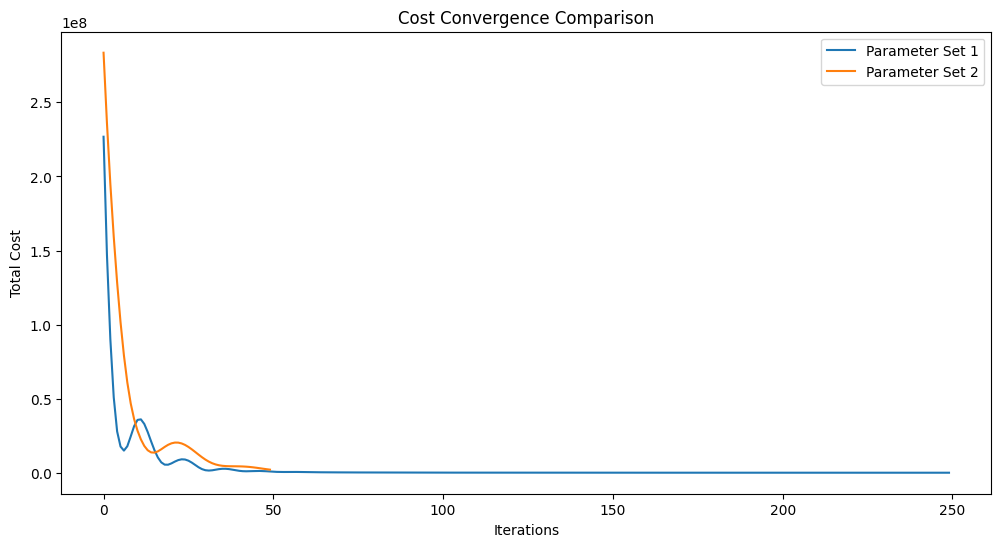

In [ ]:
# Plot the Costs Over Iterations
plt.figure(figsize=(12,6))
plt.plot(costs_original, label="Parameter Set 1")
plt.plot(costs_tuned, label="Parameter Set 2")
plt.xlabel('Iterations')
plt.ylabel('Total Cost')
plt.title('Cost Convergence Comparison')
plt.legend()
plt.savefig('cost_comparison.png')
plt.show()

In [ ]:
model_dir = '/content/drive/MyDrive/DL_Final/Models/'
model.save(model_dir +'style_transfer_resnet.h5')

In [ ]:
print(costs_original[-1])

21894.451


<function matplotlib.pyplot.show(close=None, block=None)>

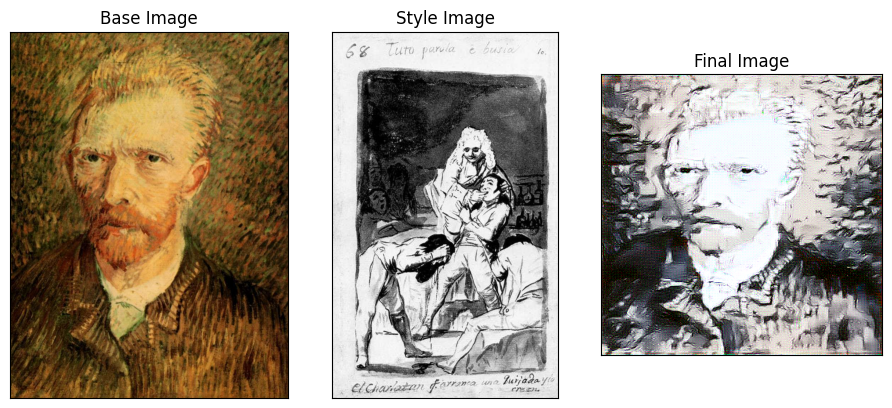

In [ ]:
plt.figure(figsize=(12,8))
dict_title={1:"Base Image",2:"Style Image",3:"Final Image"}
images={1:tf.keras.preprocessing.image.load_img(content_image_path),2:tf.keras.preprocessing.image.load_img(style_image_path), 3:original_generated_image}
for i in range(1,4):
    plt.subplot(2,4,i)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(dict_title[i])
plt.savefig('out2.png')
plt.show